<h1 align='center'> Simulation of a FACET-II type plasma wakefield accelerator</h1>
<center>
Stephen D. Webb <br>
RadiaSoft, LLC <br>
swebb@radiasoft.net</center>

Developed for a project supported by the United States Department of Energy, Office of Science, Office of High Energy Physics under contract number DE-SC0018718.

***
## Introduction

This notebook is meant to model a beam-driven plasma wakefield accelerator using nominal FACET-II parameters with an unchanging drive and witness bunch, in an effort to compute the $m=0$ wake fields from the drive bunch using our technique developed and demonstrated with the hollow channel.


***

In [1]:
## Imports

# standard python libraries
import numpy as np
from scipy import constants
from scipy.special import erfc, k0, k1

import shutil, os

%matplotlib notebook
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mpl

import h5py as hdf5

# Imports for the simulations, and setting up the plots
from fbpic.main import Simulation
from fbpic.openpmd_diag import FieldDiagnostic, ParticleDiagnostic, \
     ParticleChargeDensityDiagnostic,\
     set_periodic_checkpoint, restart_from_checkpoint
from fbpic.lpa_utils.bunch import add_elec_bunch_gaussian

# set the colormap and centre the colorbar

import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/vagrant/.pyenv/versions/py2/lib/python2.7/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm


***
## Simulation Parameters

In this section, we develop a simulation of the hollow channel. The hollow channel refers to the fact that a drive and witness bunch travel through a hollow ring of plasma -- this set up is akin to having an extremely small beam pipe. For the FBPIC simulation, this requires creating a ring of quiescent electron plasma, and a drive and witness beam initiated with self-consistent fields. We will neglect the ion motion in the plasma channel for this simulation.

The simulation uses a moving window, beginning with the drive and witness bunch outside the hollow plasma channel, then passing through, with the simulation running until the fields reach an approximate steady state. We will then use those fields to compute the wake fields and impedances, and compare to the theoretical results in [ref. 1](#References).

The hollow plasma channel has a density $n_e$ and a radius $b$, and the local plasma frequency is given by $\omega_p = \sqrt{\frac{4 \pi n_e e^2}{m_e}}$ for the electron charge $e$ and mass $m_e$. The plasma wavenumber is $k_p = \omega_p / c$. Because PIC algorithms do not like hard edges in charge density, we will use a linear ramp on the density of the plasma hollow channel, with a slope $k_{ramp}$ specified below.

The baseline parameters for our studies will be the nominal design FACET-II parameters described in [ref. 3](#References), and a plasma channel radius of thrice the beam $\sigma_r$.

In [2]:
## Domain physical parameters



## Beam parameters

# Drive bunch is gaussian

# turn the drive beam on and off, as required.
use_drive_bunch = True

drive_sigma_r = 3.65e-6  # meters
drive_sigma_z = 12.77e-6  # meters
drive_Q = 1.e10*(-1.*constants.elementary_charge)   # Coulombs
drive_N_macro = 10000
drive_gamma = 10.e9 #/5.12e5

# Witness bunch, also gaussian

# turn the witness beam on and off, as required.
use_witness_bunch = False

witness_sigma_r = 3.65e-6 #meters
witness_sigma_z = 6.38e-6  # meters
witness_Q = 4.3e9*(-1.*constants.elementary_charge)   # Coulombs
witness_N_macro = 7500
witness_gamma = 10.e9/5.12e5

trailing_distance = 150.e-6 # meters


## Plasma channel parameters

n_plasma = 4.e16        # cm^-3

# convert to per cubic meter
n_plasma *= 100**3

# derived plasma quantities
omega_p = np.sqrt(n_plasma*constants.elementary_charge**2/(constants.m_e*constants.epsilon_0))
k_p = omega_p/constants.c

lambda_p = 2.*np.pi/k_p

## Domain parameters

# Domain size, include the whole thing and some trailing distance
domain_length = 3.*lambda_p  # meters
domain_radius = lambda_p  # meters

# Grid size, resolve the drive bunch
Delta_z = min([0.05*drive_sigma_z, 0.05*lambda_p])  # meters
Delta_r = min([0.05*drive_sigma_r, 0.05*lambda_p])  # meters

# Derived quantities
Nz = int(np.rint(domain_length/Delta_z))
Nr = int(np.rint(domain_radius/Delta_r))

dt = (np.sqrt((Delta_z**2 + Delta_r**2))/constants.c)  # sec
        
# Moving window
window_v = constants.c

# start the ramp after the drive bunch has existed a while

ramp_start = domain_length
ramp_length = 5.*drive_sigma_z


# create the density function for the plasma, which is uniform
def dens_func( z, r ) :
    """Returns relative density at position z and r"""
    # Allocate relative density
    n = np.ones_like(z)
    # Make linear ramp
    n = np.where( z < ramp_start + ramp_length, (z-ramp_start)/ramp_length, n )
    # Supress density before the ramp
    n = np.where( z < domain_length + ramp_start, 0., n )
    return(n)

# We want to run the simulation just long enough for the fields to form behind the drive bunch, 
# so we will simulate for twenty bunch sigmas

sim_length = (ramp_start + ramp_length + 3*domain_length)/constants.c

Nsteps = int(sim_length/dt)-int(sim_length/dt)%100 + 1
print Nsteps

# Use only the primary azimuthal mode
Nm = 1

# Define the diagnostics
write_fields = True
write_particles = True
dump_period = Nsteps-1

3101


***
## The Simulation

Here we run the actual simulation of the beams traveling through the hollow channel.

***

In [3]:
# remove old data
if os.path.exists('./diags/hdf5'):
    shutil.rmtree('./diags/hdf5')

# Create the simulation
sim = Simulation(Nz, domain_length, Nr, domain_radius, Nm, dt, boundaries='open')
# micromanage the particle species
sim.ptcl = []

# add the gaussian drive bunch
if use_drive_bunch:
    add_elec_bunch_gaussian( sim, 
                            sig_r = drive_sigma_r, 
                            sig_z = drive_sigma_z, 
                            n_emit=0., 
                            gamma0=drive_gamma, 
                            sig_gamma=1.,
                            Q=drive_Q, 
                            N=drive_N_macro, 
                            tf=0.0, 
                            zf=.75*domain_length, boost=None)
if use_witness_bunch:
    add_elec_bunch_gaussian( sim, 
                            sig_r = witness_sigma_r, 
                            sig_z = witness_sigma_z, 
                            n_emit=0., 
                            gamma0=drive_gamma, 
                            sig_gamma=1.,
                            Q=drive_Q, 
                            N=drive_N_macro, 
                            tf=0.0, 
                            zf=.75*domain_length - trailing_distance, boost=None)

# add the plasma electrons
plasma_electrons = sim.add_new_species(q = -1.*constants.elementary_charge,
                                 m = constants.electron_mass,
                                 dens_func = dens_func, 
                                 n = n_plasma, p_nz = 8, p_nr = 8, p_nt = 1)

# Set the moving window
sim.set_moving_window(v = window_v)

# Add diagnostics
if write_fields:
    sim.diags.append( FieldDiagnostic(dump_period, sim.fld, sim.comm ) )
if write_particles:
    sim.diags.append( ParticleDiagnostic( dump_period,
                    {'electrons': sim.ptcl[0]}, sim.comm ) )
    sim.diags.append( ParticleChargeDensityDiagnostic( dump_period, sim,
                    {'electrons': sim.ptcl[-1]} ) )
    
# remove old data
# run the simulation
sim.step(Nsteps)


FBPIC (0.9.4)

Running on CPU (32 threads per process) 

Calculating initial space charge field...
Done.



|██████████████████████████████     | 2709/3101, 0:16:12 left, 2131 ms/stepK

|███████████████████████████████████| 3101/3101, 0:00:02 left, 2238 ms/step
Total time taken (with compilation): 1:28:26
Average time per iteration (with compilation): 1711 ms



In [7]:
# Plot the particle and field data

file = hdf5.File('./diags/hdf5/data00003100.h5','r')
data = file.get('data/')
step = data.get('3100')
ptcls = step.get('particles')
electrons = ptcls.get('electrons')
pos = electrons.get('position')

fields = step.get('fields')
rho = fields.get('rho')

# convert to number density
therho = rho[0,:,:]/constants.elementary_charge
# convert to cm^-3
therho /= 100.**3

Es = fields.get('E')
Ez = Es.get('z')
Er = Es.get('r')
theEz = Ez[0,:,:]
theEr = Er[0,:,:]

Bs = fields.get('B')
Bt = Bs.get('t')
theBt = Bt[0,:,:]

x = pos.get('x')
y = pos.get('y')
z = pos.get('z')

xPos = x[:]
yPos = y[:]
z = z[:]
r = np.sqrt(xPos**2 + yPos**2)

file.close()

<IPython.core.display.Javascript object>


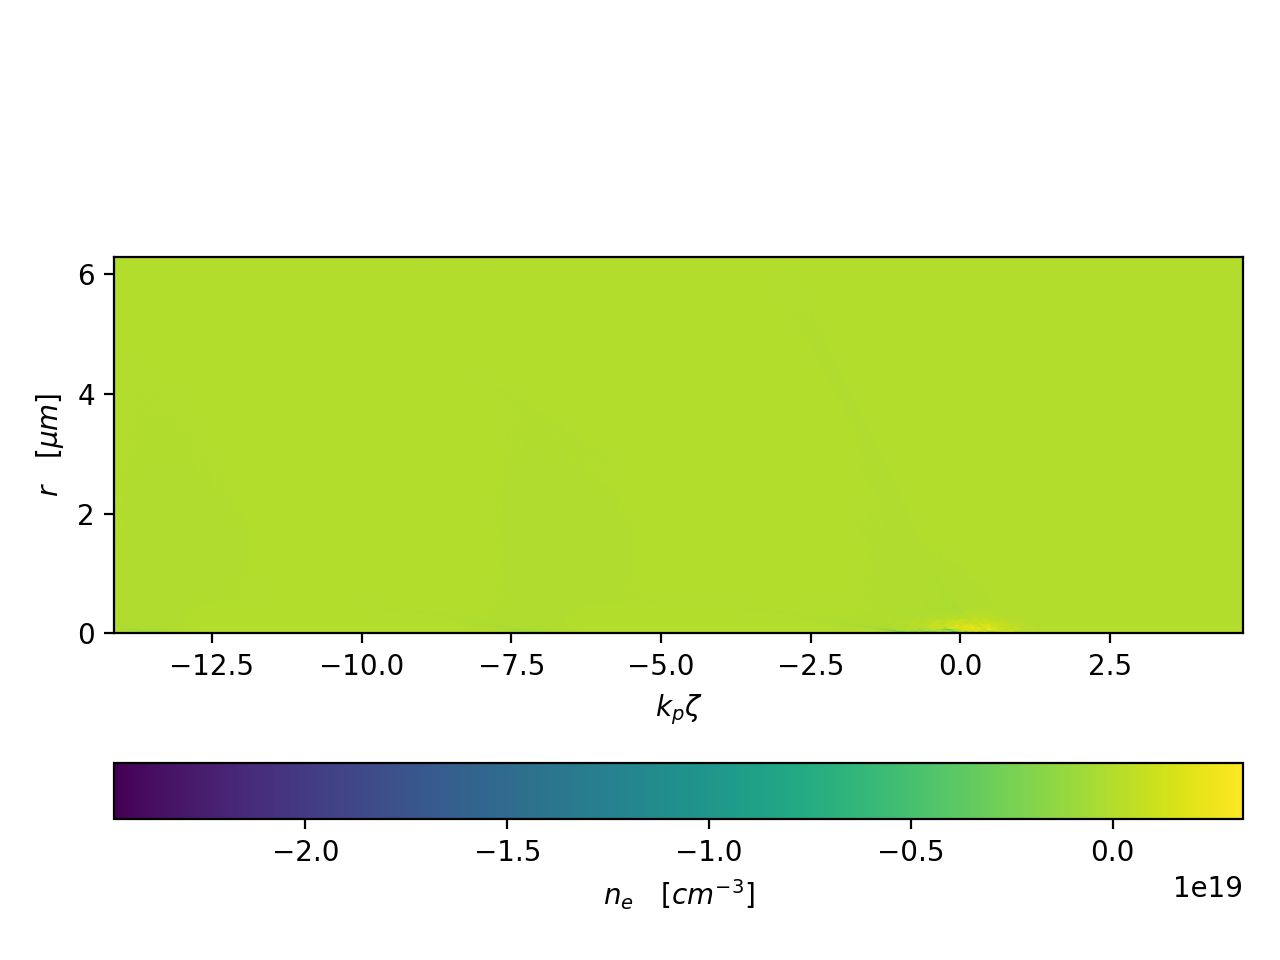

In [8]:
Rads = np.linspace(0., domain_radius, Nr)
zeta = np.linspace(0., domain_length, Nz)

# move zeta so zero is centered on the drive bunch
z_avg = np.average(z)
z_avg -= constants.c * dt*(Nsteps-1)

zeta -= z_avg

zz, RR = np.meshgrid(zeta, Rads)

fig = plt.figure()

plt.imshow(therho,extent=[k_p*zeta[0],k_p*zeta[-1], k_p*Rads[0], k_p*Rads[-1]], cmap='viridis', origin='lower')
plt.xlabel(r'$k_p \zeta$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$n_e \quad [cm^{-3}]$')

plt.tight_layout()

plt.savefig('rho.png')


In [ ]:
fig = plt.figure()

# Fix the midpoint to zero field

ezmax = np.amax(theEz*1.e-9)
ezmin = np.amin(theEz*1.e-9)
ezavg = 0.

plt.imshow(theEz*1.e-9,extent=[k_p*zeta[0], k_p*zeta[-1], k_p*Rads[0], k_p*Rads[-1]], 
           cmap='RdBu', origin='lower', norm=MidpointNormalize(midpoint=ezavg,vmin=ezmin, vmax=ezmax))
plt.xlabel(r'$k_p \zeta$')
plt.ylabel(r'$k_p r$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_z \quad [GV/m]$')

plt.savefig('Ez.png')


In [ ]:
fig = plt.figure()

Ez_lineout = theEz[1,:]*1.e-9

plt.plot(k_p* zeta, Ez_lineout)
plt.xlabel(r'$k_p \zeta$')
plt.ylabel(r'$E_z$ [GV/m]')


In [ ]:
fig = plt.figure()

Fr = (theEr - constants.speed_of_light*(theBt))*1.e-9

frmax = np.amax(Fr)
frmin = np.amin(Fr)
fravg = 0.

plt.imshow(Fr,extent=[k_p*zeta[0], k_p*zeta[-1], k_p*Rads[0], k_p*Rads[-1]], 
           cmap='RdBu', origin='lower', norm=MidpointNormalize(midpoint=fravg,vmin=frmin, vmax=frmax))
plt.xlabel(r'$\zeta = z - c t \quad [\mu m]$')
plt.ylabel(r'$r \quad [\mu m]$')
cbar = plt.colorbar(orientation='horizontal')
cbar.set_label(r'$E_r - c B_\theta \quad [GV/m]$')
plt.title(r'Transverse force $E_r - c B_\theta$')
plt.tight_layout()

plt.savefig('Fr.png')

***
## References

> 1. C. B. Schroeder, D. H. Whittum, and J. S. Wurtele, "Multimode Analysis of the Hollow Plasma Channel Wakefield Accelerator", _Phys. Rev. Lett._ __82__, 1177 (1999). [https://doi.org/10.1103/PhysRevLett.82.1177](https://doi.org/10.1103/PhysRevLett.82.1177)

> 2. R. Lehe, M. Kirchen, I. A. Andriyash, B. B. Godfrey, and J.-L. Vay, "A spectral, quasi-cylindrical and dispersion-free Particle-In-Cell algorithm", _Comp. Phys. Comm._ __203__, pp. 66-82 (2016). [https://doi.org/10.1016/j.cpc.2016.02.007](https://doi.org/10.1016/j.cpc.2016.02.007)

> 3. C. Joshi _et al._ "Plasma wakefield acceleration experiments at FACET II", _Plasma Phys. Control. Fusion_ __60__, 3 (2018).

> 4. A. W. Chao, "Physics of Collective Beam Instabilities in High Energy Accelerators", John Wiley & Sons (1993)

> 5. C. A. Lindstrom _et al._ "Measurement of Transverse Wakefields Induced by a Misaligned Positron Bunch in a Hollow Channel Plasma Accelerator", _Phys. Rev. Lett._ __120__, 124802 (2018).